In [4]:
from simsegpocket_models_pyg import feature_model

In [8]:
# sample_data
import torch

x = torch.randn(1000,8)
pos = torch.randn(1000,3)
batch = torch.zeros(1000,dtype=int)
x,pos,batch

(tensor([[-0.5698,  1.5871, -0.3492,  ...,  1.2728, -0.0779,  1.0349],
         [ 0.2808,  1.1698, -0.1772,  ...,  0.2203,  0.1126, -0.1948],
         [ 0.5002, -0.6761, -0.2840,  ..., -0.1335,  0.1993, -0.8594],
         ...,
         [ 0.3602,  0.1545,  0.4185,  ..., -0.0532, -1.8379,  0.1008],
         [ 0.4399, -0.6454,  0.9472,  ..., -0.3940, -0.3388, -2.3749],
         [-0.9492,  1.2241, -1.2119,  ...,  2.0235,  0.3099,  1.5840]]),
 tensor([[-0.2159, -0.6978, -1.7104],
         [-0.9992,  0.1249,  0.4562],
         [-0.4550,  0.5572, -0.6617],
         ...,
         [ 0.4853,  1.2160,  0.4453],
         [ 0.0133,  0.3681, -0.7862],
         [-1.4263, -0.7420,  1.5383]]),
 tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [ ]:
#!pip install torchviz

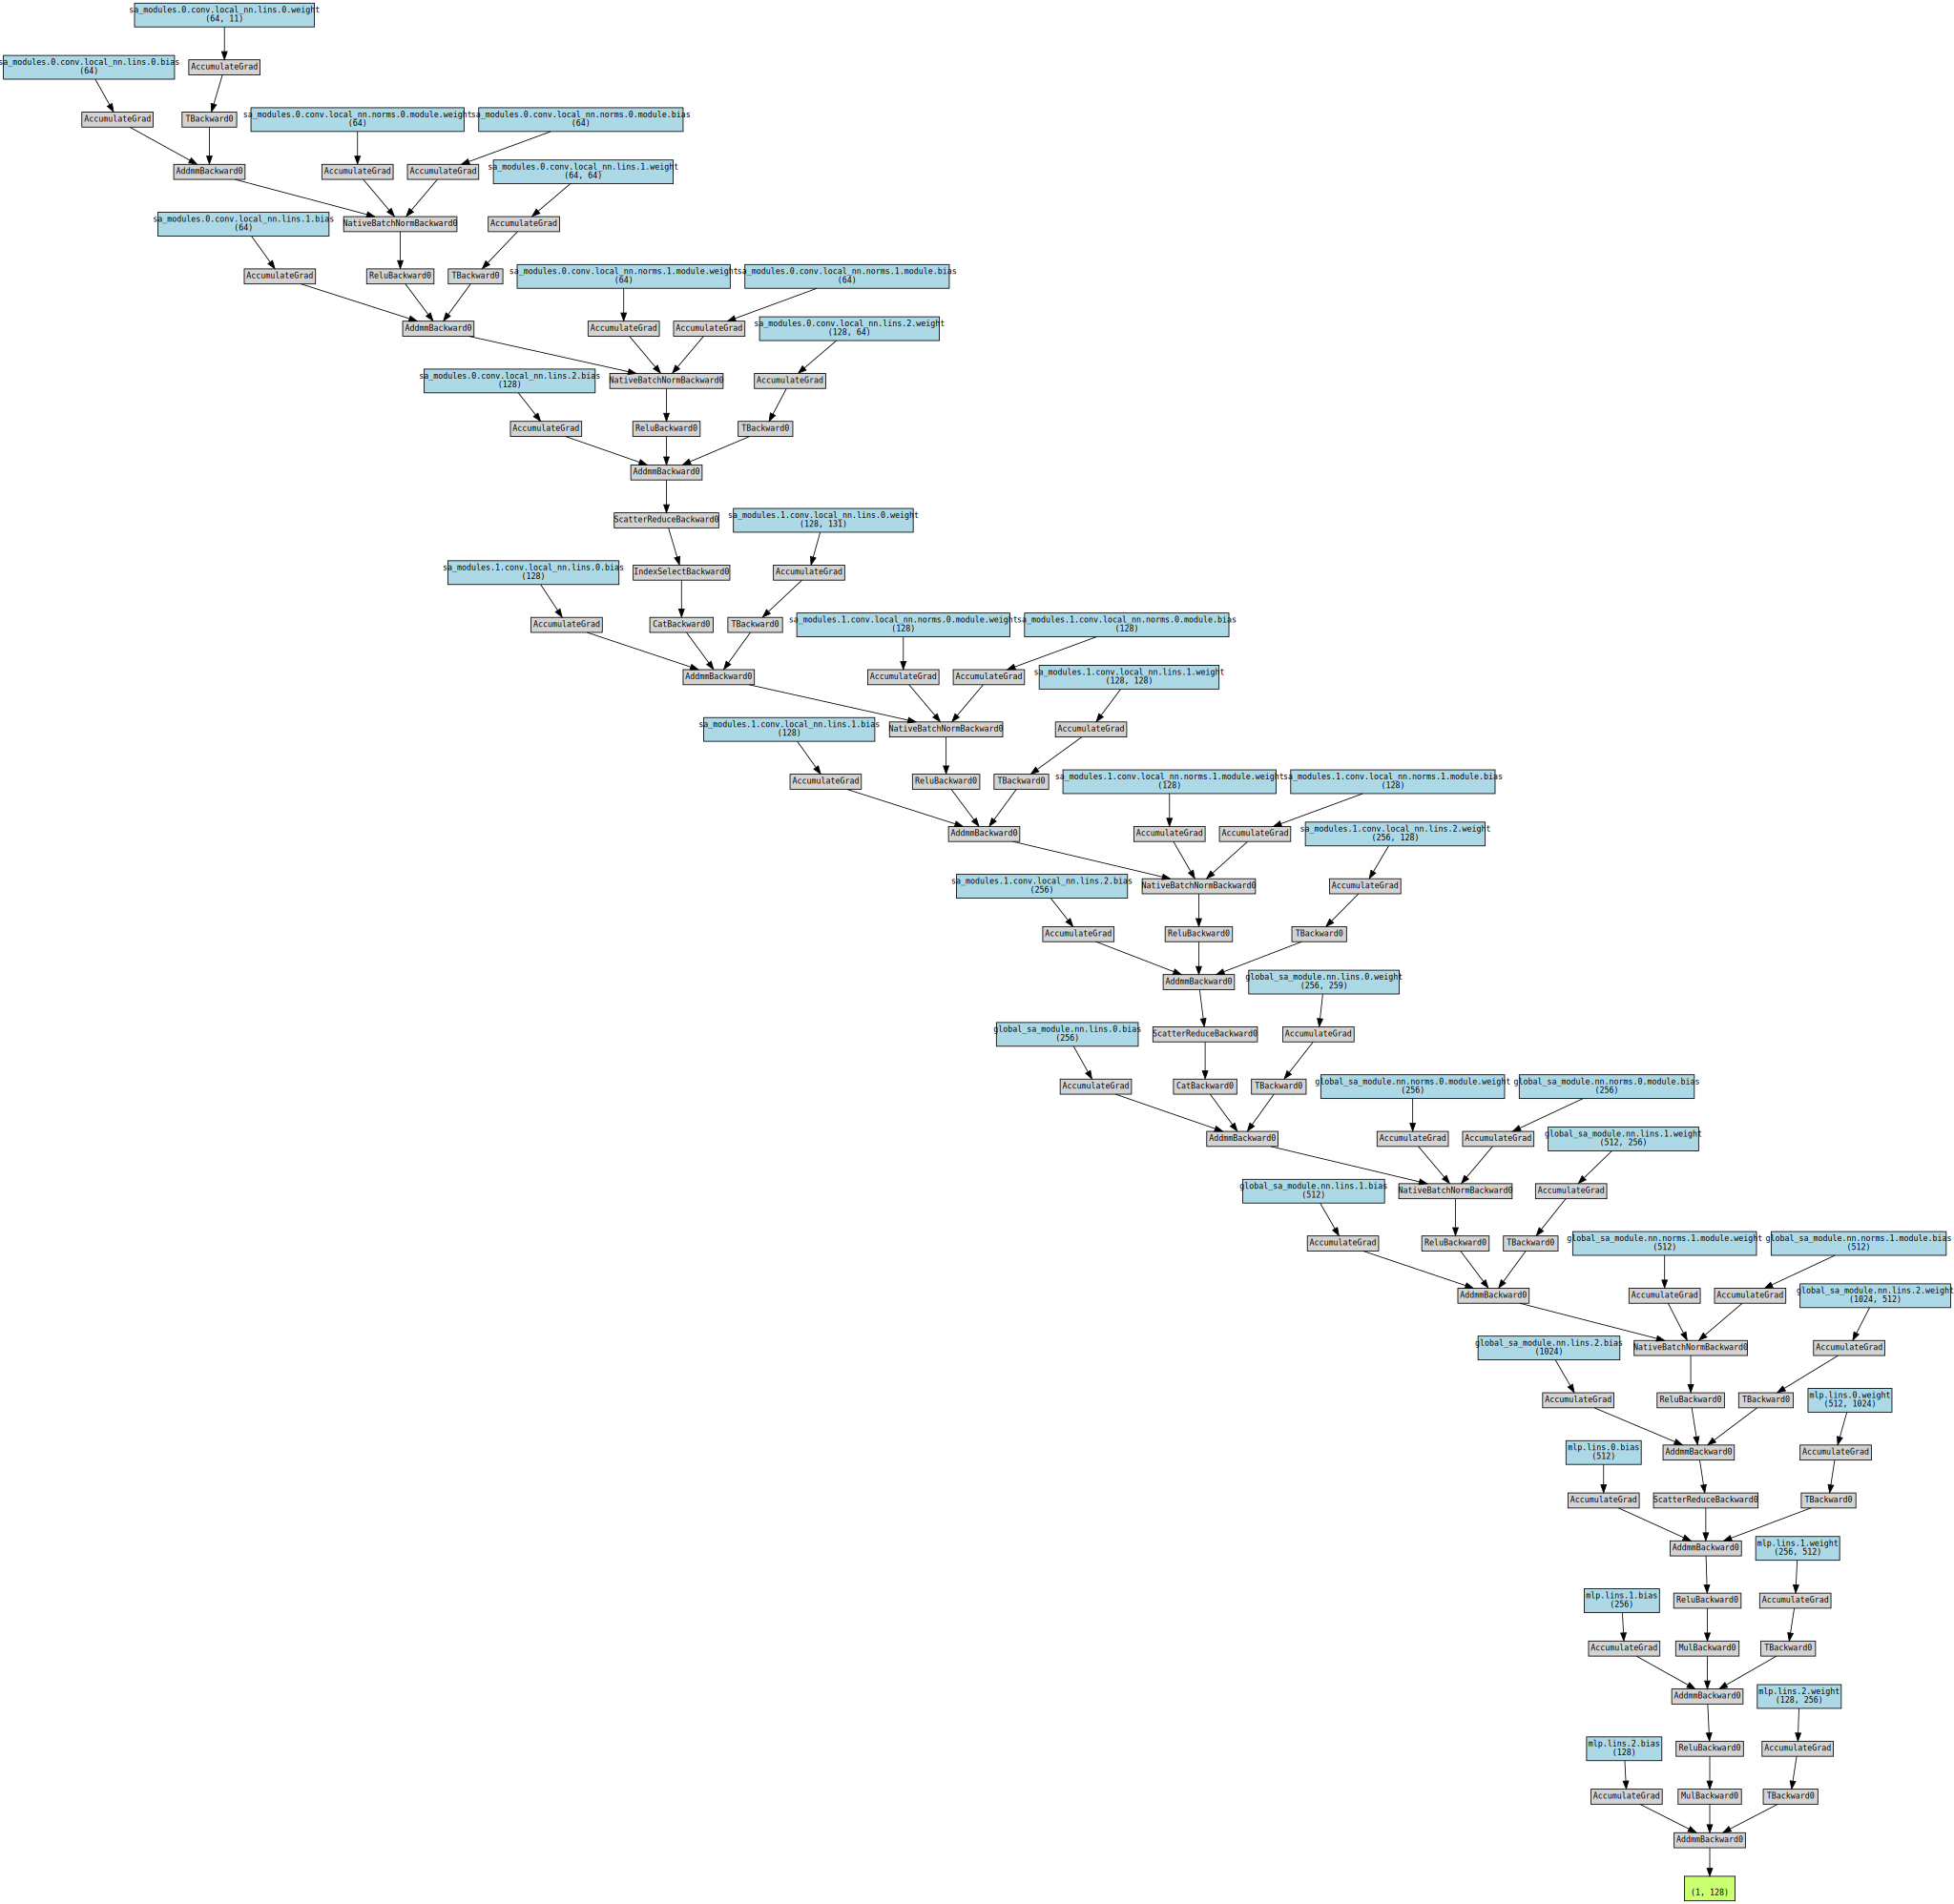

In [14]:
import torchviz

model_feature = feature_model(128,8)
dot = torchviz.make_dot(model_feature(x, pos, batch), params=dict(model_feature.named_parameters()))
dot

In [37]:
from simsegpocket_models_pyg import SAModule
from torch_geometric.nn import MLP
import logging

x0, pos0, batch0 = x,pos,batch
sa_module1 = SAModule(0.5, 1.0, MLP([x0.size(1) + 3, 64, 64, 128]))
x1, pos1, batch1 = sa_module1(x0,pos0,batch0)
print(x1.size(), pos1.size(), batch1.size())
sa_module2 = SAModule(0.5, 2.0, MLP([x1.size(1) + 3, 128, 128, 256]))
x2, pos2, batch2 = sa_module2(x1, pos1, batch1)
print(x2.size(), pos2.size(), batch2.size())


torch.Size([500, 128]) torch.Size([500, 3]) torch.Size([500])
torch.Size([250, 256]) torch.Size([250, 3]) torch.Size([250])


In [72]:
from torch_geometric.nn.pool import knn
row,col = knn(pos1,pos2,64,batch1,batch2)
# row from x2, col from x1
# up sampling local feature
edge_index = torch.stack([row,col], dim=0)
x1_new = PointNetConv(local_nn=MLP([x2.size(1)+3,256,256,128]),add_self_loops=True)((x2,x1),(pos2,pos1),edge_index)
print(x1_new.size())
x1_concat = torch.cat([x1_new,x1], dim=1)
print(x1_concat.size())
row,col = knn(pos0,pos1,64,batch0,batch1)
edge_index = torch.stack([row,col], dim=0)
x0_new = PointNetConv(local_nn=MLP([x1_concat.size(1)+3,256,256,128]),add_self_loops=True)((x1_concat,x0),(pos1,pos0),edge_index)
print(x0_new.size())
linear = nn.Linear(8,128)
x0_concat = torch.cat([x0_new,linear(x0)], dim=1)
print(x0_concat.size())

seq = nn.Sequential(
    nn.Linear(256,128),
    nn.ReLU(),
    nn.Linear(128,64),
    nn.ReLU(),
    nn.Linear(64,32),
    nn.ReLU(),
    nn.Linear(32,1),
    nn.Sigmoid()
)
x_last = seq(x0_concat)
print(x_last.size(), x_last)

torch.Size([500, 128])
torch.Size([500, 256])
torch.Size([1000, 128])
torch.Size([1000, 256])
torch.Size([1000, 1]) tensor([[0.5212],
        [0.5215],
        [0.5243],
        [0.5181],
        [0.5243],
        [0.5256],
        [0.5194],
        [0.5271],
        [0.5212],
        [0.5227],
        [0.5227],
        [0.5221],
        [0.5168],
        [0.5294],
        [0.5280],
        [0.5182],
        [0.5212],
        [0.5230],
        [0.5229],
        [0.5195],
        [0.5209],
        [0.5202],
        [0.5201],
        [0.5208],
        [0.5223],
        [0.5193],
        [0.5229],
        [0.5190],
        [0.5251],
        [0.5224],
        [0.5209],
        [0.5230],
        [0.5230],
        [0.5243],
        [0.5207],
        [0.5192],
        [0.5194],
        [0.5238],
        [0.5195],
        [0.5256],
        [0.5168],
        [0.5226],
        [0.5223],
        [0.5255],
        [0.5242],
        [0.5188],
        [0.5222],
        [0.5204],
        [0.5257],
  

In [ ]:
from torch_geometric.nn import MLP, PointNetConv, fps, global_max_pool, radius, knn, norm

class segmentation_model(torch.nn.Module):
    def __init__(self,in_channels,num_SAModule=2,dropout=0.5):
        self.sa_modules = torch.nn.ModuleList()
        ratio = 0.5
        radius = 1.0
        hidden = 16
        for i in range(num_SAModule):
            self.sa_modules.append(SAModule(ratio, radius, MLP([in_channels + 3, hidden, hidden, hidden * 2], add_self_loops=False)))
            radius *= 2
            hidden *= 2
            in_channels = hidden
        self.middle_layer = MLP([in_channels + 3, hidden, hidden, hidden * 2], add_self_loops=True)
        self.point_net_convs = torch.nn.ModuleList()
        self.up_sample_convs = torch.nn.ModuleList()
        for i in range(num_SAModule):
            self.point_net_convs.append(PointNetConv(local_nn=MLP([in_channels.size(1)+3, hidden, hidden, hidden // 2]),add_self_loops=True))
            self.up_sample_convs.append(torch.nn.Sequential(
                torch.nn.Linear(hidden, hidden//2),
                norm.BatchNorm(hidden//2),
                torch.nn.ReLU()
            ))
            hidden //= 2
            in_channels = hidden
        self.fc = MLP([in_channels,hidden,hidden,1])
        self.sigmoid = torch.nn.Sigmoid()


    def forward(self,x,pos,batch):
        sa_out_list = []
        sa_out = (x, pos, batch)
        sa_out_list.append(sa_out)
        for sa_module in self.sa_modules:
            sa_out = sa_module(*sa_out)
            x, pos, batch = sa_out
            sa_out_list.append(sa_out)
        xl, posl, batchl = sa_out_list.pop()
        for point_net_conv, up_sample_conv in zip(self.point_net_convs, self.up_sample_convs):
            sa_out = sa_out_list.pop()
            x, pos, batch = sa_out
            row, col = knn(pos,posl,64,batch,batchl)
            edge_index = torch.stack([row,col], dim=0)
            x_new = point_net_conv((xl,x),(posl,pos),edge_index)
            x_concat = torch.cat([x_new,x], dim=1)
            xl = up_sample_conv(x_concat)
            posl, batchl = pos, batch
        xl = self.fc(x,batch)
        xl = self.sigmoid(x)
        return xl, posl, batchl